Loading all libraries necessary to examine the data


In [235]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import re
import math



code to receive info as csv and convert it to a pandas data frame

In [236]:
df_games = pd.read_csv("/kaggle files/games.csv")
df_sample_submission = pd.read_csv("/kaggle files/sample_submission.csv")
df_test = pd.read_csv("/kaggle files/test.csv")
df_train = pd.read_csv("/kaggle files/train.csv")
df_turns = pd.read_csv("/kaggle files/turns.csv")

starting to perform eda of the data to search the types of the characteristics

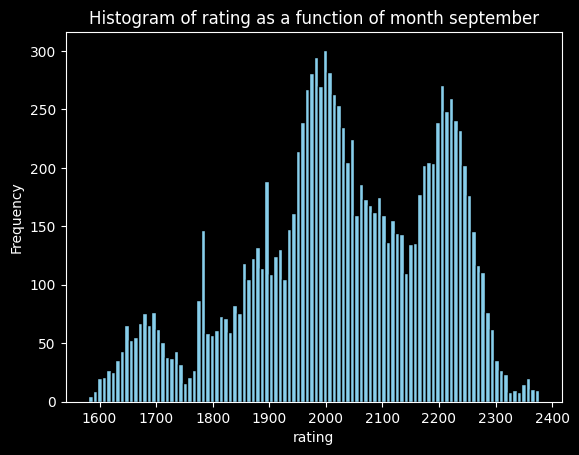

In [237]:
# we go through each data frame and extract only the features that are relevant for us
# EDA for the train data
# CURR_FEATURE = "rating"

# trying to watch if there's a connection between the month and the rating
month_rating_analysis_df = pd.merge(df_games[["game_id","created_at"]], df_train[["game_id", "rating"]], how="inner",  on="game_id")
# doing EDA per month
month_rating_analysis_df['created_at'] = pd.to_datetime(month_rating_analysis_df['created_at'],
                                                        format='%Y-%m-%d %H:%M:%S')
month_rating_analysis_df["month"] = month_rating_analysis_df['created_at'].dt.month
month_rating_analysis_df["day"] = month_rating_analysis_df['created_at'].dt.day

# plotting a graph for every month
month_rating_analysis_df_january = month_rating_analysis_df[month_rating_analysis_df["month"] == 9]
# mean_value = np.mean(df_train[CURR_FEATURE])
# median_value = np.median(df_train[CURR_FEATURE])
# Add a vertical line for the mean
plt.hist(month_rating_analysis_df_january["rating"], bins=100, color='skyblue', edgecolor='black')
# plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
# plt.axvline(median_value, color='green', linestyle='solid', linewidth=2, label=f'Median: {median_value:.2f}')

# Add labels and a title for clarity
plt.title("Histogram of rating as a function of month september")
plt.xlabel("rating")
plt.ylabel("Frequency")

# Display the plot
plt.show()

aggregate all data into one row for every game. create all data frames for our usage

In [238]:
# creating a new data frame to edit the train file
df_train["score_rival"] = df_train.groupby("game_id")["score"].transform("sum") - df_train["score"]
df_train = df_train.merge(
    df_train,
    on="game_id",
    suffixes=("", "_my_rival")
)

df_train = df_train[df_train["nickname"] != df_train["nickname_my_rival"]]
df_train = df_train.drop(columns=['rating_my_rival', 'score_my_rival', 'score_rival_my_rival'])
df_train = df_train.rename(columns={"nickname_my_rival": "rival"})
df_train.head()

,game_id,nickname,score,rating,score_rival,rival
1,2,Super,488,NaN,401,BetterBot
2,2,BetterBot,401,2000.0,488,Super
5,7,STEEBot,377,2082.0,379,Priya1
6,7,Priya1,379,NaN,377,STEEBot
9,11,STEEBot,334,1829.0,462,TileRunner


In [239]:
# create onw row for every game to process
df_train_output = df_train[["game_id", "nickname", "rating"]]
df_train_input = df_train.merge(df_turns, how="left", on="game_id").drop("rating", axis=1)
df_train_input = df_train_input.merge(df_games, how="left", on="game_id")

preprocessing the main collective table - renaming labels and parsing values

In [240]:
# PREPROCESSING THE DATA TO THE MAJOR COLLECTIVE TABLE
# perform analyzing over the data in order to extract more knowledge
df_one_row_per_game = pd.DataFrame()

# encoding the data
# a bit processing of the data
df_train_input['created_at'] = pd.to_datetime(df_train_input['created_at'],
                                                        format='%Y-%m-%d %H:%M:%S')
df_train_input["month"] = df_train_input['created_at'].dt.month
df_train_input["day"] = df_train_input['created_at'].dt.day
df_train_input["hour"] = df_train_input['created_at'].dt.hour
df_train_input['first'] = (df_train_input['first'] == df_train_input['nickname_x']).astype(int)
df_train_input['winner'] = (df_train_input['first'] != df_train_input['winner']).astype(int)
df_train_input['nickname_y'] = (df_train_input['nickname_y'] == df_train_input['nickname_x']).astype(int)

# creating columns based on bots
BOT_NAMES = ["STEEBot", "BetterBot", "HastyBot"]
for bot_name in BOT_NAMES:
    df_train_input["played_against_" + bot_name] = (df_train_input["rival"] == bot_name)

# removing all columns that we cant extract relevant data from
df_train_input = df_train_input.drop("created_at", axis=1).drop("location", axis=1).drop("score_y", axis=1)

# Rename columns (once)
df_train_input = df_train_input.rename(columns={
    "nickname_x": "player_to_predict",
    "nickname_y": "current_player",
    "score_x": "total_score"
})

# adding columns of average move size
# deducting unnecessary characters
df_train_input['move'] = df_train_input['move'].str.upper()
df_train_input['move'] = df_train_input['move'].str.replace(r"[-()]", '', regex=False)
df_train_input['move_average_size'] = df_train_input['move'].astype(str).str.len()

# adding the rack size for every turn
df_train_input['rack_average_size'] = df_train_input['rack'].astype(str).str.len()


# dealing with the need to calculate mean only for the
# relevant turns for every player
columns_to_change = ["rack", "points", "turn_type", "move",
                     "move_average_size", "rack_average_size"]


for current_col in columns_to_change:
    # creating a data set for rival's results
    df_train_input[current_col + "_rival"] =  df_train_input[current_col] * (1 - df_train_input["current_player"])
    # creating a data set for the player's results
    df_train_input[current_col] =  df_train_input[current_col] * df_train_input["current_player"]

# adding dummies to the wanted values
df_train_input = pd.get_dummies(df_train_input, columns=["time_control_name",
                                                         "game_end_reason", "lexicon",
                                                         "turn_type_rival", "turn_type", "rating_mode"])
df_train_input = df_train_input.drop("turn_type_rival_", axis=1).drop("turn_type_", axis = 1)

code for dealing with creation of new columns from existing ones - mainly dummies and one hot encoding

In [241]:
# encoding the rack of tiles to a one - hot encoding
# Define all possible letters + blank tile
classes = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ?")

# Convert the string rack column into counts of each letter
counts_df = (
    df_train_input["rack"]
    .fillna("")                # handle missing values
    .str.findall(r"[A-Z?]")    # extract letters / blank tiles
    .explode()                 # one letter per row
    .groupby(level=0)          # group back by original row
    .value_counts()            # count letters per row
    .unstack(fill_value=0)     # rows = racks, columns = letters
    .reindex(columns=classes, fill_value=0)  # ensure fixed column order
)

# Replace the original 'rack' column with multi-hot count encoding
prefix = "rack_"
counts_df.columns = [prefix + col for col in counts_df.columns]
df_train_input = pd.concat([df_train_input.drop(columns="rack"), counts_df], axis=1)

# convert the move column into counts of each letter
classes = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ.")
counts_df = (
    df_train_input["move"]
    .fillna("")                # handle missing values
    .str.findall(r"[A-Z.]")    # extract letters / blank tiles
    .explode()                 # one letter per row
    .groupby(level=0)          # group back by original row
    .value_counts()            # count letters per row
    .unstack(fill_value=0)     # rows = racks, columns = letters
    .reindex(columns=classes, fill_value=0)  # ensure fixed column order
)

prefix = "move_"
counts_df.columns = [prefix + col for col in counts_df.columns]
df_train_input = pd.concat([df_train_input.drop(columns="move"), counts_df], axis=1)

df_train_input.head()

,game_id,player_to_predict,total_score,score_rival,rival,turn_number,current_player,points,first,winner,...,move_R,move_S,move_T,move_U,move_V,move_W,move_X,move_Y,move_Z,move_.
0,2,Super,488,401,BetterBot,1,1,24,1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Super,488,401,BetterBot,2,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Super,488,401,BetterBot,3,1,34,1,0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,2,Super,488,401,BetterBot,4,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,Super,488,401,BetterBot,5,1,44,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


dealing with data aggregation

In [242]:
#AGGREGATION OF DATA
# after editing the needed data - we now aggregate it
BOT_NAMES = ["STEEBot", "BetterBot", "HastyBot"]
agg_dict = {
    'total_score': ('total_score', 'first'),
    'game_duration_seconds': ("game_duration_seconds", 'first'),
    'first': ("first", 'first'),
    'winner': ("winner", 'first'),
    'turn_number': ("turn_number",'count'),
    "points_mean_in_a_game": ("points", lambda x: x[x != 0].mean()),
    "points_min": ("points", lambda x: x[x != 0].min()),
    'points_max':("points", lambda x: x[x != 0].max()),
    "move_average_size": ("move_average_size", lambda x: x[x != 0].mean()),
    "rack_average_size": ("rack_average_size", lambda x: x[x != 0].mean()),
    "move_.": ("move_.", lambda x:  x.dropna().mean()),
    "day": ("day", "first"),
    "month": ("month", "first"),
    "hour": ("hour", "first"),
    "played_against_STEEBot": ("played_against_STEEBot", 'first'),
    "played_against_BetterBot": ("played_against_BetterBot", 'first'),
    "played_against_HastyBot": ("played_against_HastyBot", 'first'),
    "lexicon_CSW21": ("lexicon_CSW21", "first"),
    "lexicon_ECWL": ("lexicon_ECWL", "first"),
    "lexicon_NWL20": ("lexicon_NWL20", "first"),
    "rating_mode_CASUAL": ("rating_mode_CASUAL", 'first'),
    "rating_mode_RATED": ("rating_mode_RATED", 'first')
}

df_one_row_per_game = (
    df_train_input
    .groupby(['game_id', 'player_to_predict'], sort=False)
    .agg(**agg_dict)
    .reset_index()
)
df_one_row_per_game.head()

,game_id,player_to_predict,total_score,game_duration_seconds,first,winner,turn_number,points_mean_in_a_game,points_min,points_max,...,month,hour,played_against_STEEBot,played_against_BetterBot,played_against_HastyBot,lexicon_CSW21,lexicon_ECWL,lexicon_NWL20,rating_mode_CASUAL,rating_mode_RATED
0,2,Super,488,364.214418,1,0,26,40.666667,2.0,94.0,...,8,19,False,True,False,True,False,False,False,True
1,2,BetterBot,401,364.214418,0,1,26,33.416667,8.0,85.0,...,8,19,False,False,False,True,False,False,False,True
2,7,STEEBot,377,385.599607,0,1,27,26.928571,9.0,62.0,...,8,3,False,False,False,True,False,False,False,True
3,7,Priya1,379,385.599607,1,0,27,31.583333,9.0,68.0,...,8,3,True,False,False,True,False,False,False,True
4,11,STEEBot,334,501.739156,0,1,29,23.857143,2.0,76.0,...,8,1,False,False,False,False,False,True,True,False


creating a new data frame based on statistics of all games of the same player, and all the games played against him

In [243]:
#AGGREGATION OF DATA FOR THE SAME USER
# after editing the needed data - we now aggregate it
# removing turn number - mean, rack_average_size_mean
agg_dict = {
    'total_score_max': ('total_score', 'max'),
    'total_score_min': ('total_score', lambda x: x[x != 0].min()),
    'total_score':('total_score', lambda x: x[x != 0].drop_duplicates().mean()),
    'points': ('points', lambda x: x[x != 0].drop_duplicates().mean())
}

mean_cols = (
    [c for c in df_train_input.columns if c.startswith("rack_") and "rival" not in c] +
    [c for c in df_train_input.columns if c.startswith("move_") and "rival" not in c]
)

agg_dict.update({c: (c, lambda x: pd.Series(x.dropna()).mean()) for c in mean_cols})

df_one_row_per_user = (
    df_train_input
    .groupby(['player_to_predict'], sort=False)
    .agg(**agg_dict)
    .reset_index()
)

# aggregating data based on the already existent table
# this meant to make the average not based on the number of turns in a game
agg_dict = {
    'winner': ('winner', 'mean'),
    'turn_number': ('turn_number', 'mean'),
    'game_duration_seconds':('game_duration_seconds', 'mean'),
}

df_one_row_per_user = pd.concat([df_one_row_per_user,
                                 df_one_row_per_game.groupby(['player_to_predict'],
                                                             sort=False).agg(**agg_dict).reset_index()[["winner", "turn_number", "game_duration_seconds"]],],
                                axis=1)

df_one_row_per_user.columns = [col + "_mean" if col not in ["player_to_predict", "total_score_max", "total_score_min"] else col for col in df_one_row_per_user.columns]

creating a new data frame based on statistics of all players that played against the player and the statistics regarding their performance against him

In [244]:
# after editing the needed data - we now aggregate it
agg_dict = {
    'score_rival': lambda s: s.unique().mean(),
    'points_rival':  lambda x: x[x != 0].mean(),
    'move_average_size_rival': lambda x: x[x != 0].mean()
}

df_one_row_per_rivals = (
    df_train_input
    .groupby(['player_to_predict'], sort=False)
    .agg(agg_dict)
    .reset_index()
)

df_one_row_per_rivals.columns = [col + "_mean_oponent" if col != "player_to_predict" else col for col in df_one_row_per_rivals.columns]

merging all data tables created

In [245]:
#CREATING FILE
# adding ratings for the y values in the training
ratings = (
    df_train_output[['game_id', 'nickname', 'rating']]
    .drop_duplicates()
    .rename(columns={'nickname': 'player_to_predict'})
)

df_one_row_per_game = df_one_row_per_game.merge(
    df_one_row_per_user,
    on=['player_to_predict'],
    how='left'
)

df_one_row_per_game = df_one_row_per_game.merge(
    df_one_row_per_rivals,
    on=['player_to_predict'],
    how='left'
)

df_one_row_per_game = df_one_row_per_game.merge(
    ratings,
    on=['game_id', 'player_to_predict'],
    how='left'
)

df_one_row_per_game.head()

,game_id,player_to_predict,total_score,game_duration_seconds,first,winner,turn_number,points_mean_in_a_game,points_min,points_max,...,move_Y_mean,move_Z_mean,move_._mean,winner_mean,turn_number_mean,game_duration_seconds_mean,score_rival_mean_oponent,points_rival_mean_oponent,move_average_size_rival_mean_oponent,rating
0,2,Super,488,364.214418,1,0,26,40.666667,2.0,94.0,...,0.074830,0.035583,0.484563,0.435714,27.400000,219.381528,404.500000,29.780577,4.491923,NaN
1,2,BetterBot,401,364.214418,0,1,26,33.416667,8.0,85.0,...,0.072728,0.035511,0.667126,0.541089,29.588982,544.635315,353.955789,25.980155,3.915378,2000.0
2,7,STEEBot,377,385.599607,0,1,27,26.928571,9.0,62.0,...,0.081242,0.039303,0.543591,0.541046,26.977289,395.985255,353.478360,27.980459,4.145415,2082.0
3,7,Priya1,379,385.599607,1,0,27,31.583333,9.0,68.0,...,0.074954,0.032450,0.498629,0.427711,26.698795,582.572377,443.415929,33.193038,4.674855,NaN
4,11,STEEBot,334,501.739156,0,1,29,23.857143,2.0,76.0,...,0.081242,0.039303,0.543591,0.541046,26.977289,395.985255,353.478360,27.980459,4.145415,1829.0


going over the finished data set and filtering unwanted users and participants


In [246]:
# THRESHOLD = 0.1
# # going through the data and finding which user has more than 85 percents of his game played as "casual"
# # as they can have a negative effect on the output
# agg_dict = {
#     "rating_mode_CASUAL" : ("rating_mode_CASUAL", 'mean')
# }
# df_check_users = (
#     df_one_row_per_game.groupby(['player_to_predict'], sort=False)
#     .agg(**agg_dict)
#     .reset_index()
# )
#
# names_to_disqualify = df_check_users[df_check_users["rating_mode_CASUAL"] > THRESHOLD]['player_to_predict']
#
# # updating the data
# df_one_row_per_game = df_one_row_per_game[
#     ~df_one_row_per_game["player_to_predict"].isin(names_to_disqualify)
# ]

creating a .csv file of the data

In [247]:
df_one_row_per_game.to_csv('df_one_row_per_game.csv', index=False)